In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import cv2

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'

In [4]:
class CustomModel2(nn.Module):
    def __init__(self, input_dim, cls):
        super(CustomModel2, self).__init__()
        self.feature = nn.Sequential(
            # nn.GaussianNoise(0.01),
            nn.Conv1d(
                in_channels=1, out_channels=32, kernel_size=8, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(
                in_channels=32, out_channels=32, kernel_size=8, stride=2, padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Flatten(),
        )

        self.feature_x_x_x = nn.Sequential(
            nn.Conv1d(
                in_channels=1, out_channels=16, kernel_size=18, stride=2, padding=8
            ),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(
                in_channels=16, out_channels=16, kernel_size=18, stride=4, padding=8
            ),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Flatten(),
        )
        self.feature_f = nn.Sequential(nn.Flatten())
        self.combined_features = nn.Sequential()

        self.fc = nn.Sequential(
            nn.Linear(
                52048, 1024
            ),  
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, cls)
        )

    def forward(self, x):
        x1 = self.feature(x)
        x4 = self.feature_x_x_x(x)
        x6 = self.feature_f(x)
        combined_features = torch.cat((x1, x4, x6), dim=1)
        fc_x = self.fc(combined_features)
        return fc_x

In [5]:
input_size = 1
output_size = 7
model_ft = CustomModel2(input_size, output_size)


In [6]:
checkpoint = torch.load(
   "/home/woody/iwi5/iwi5095h/line_profile/Results/results/mean-std/fcn/fcn_model.pt",
    map_location=torch.device("cpu"),
)

model_ft.load_state_dict(checkpoint["model_state_dict"])



<All keys matched successfully>

In [7]:
print(model_ft)

CustomModel2(
  (feature): Sequential(
    (0): Conv1d(1, 32, kernel_size=(8,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 32, kernel_size=(8,), stride=(2,), padding=(2,))
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (feature_x_x_x): Sequential(
    (0): Conv1d(1, 16, kernel_size=(18,), stride=(2,), padding=(8,))
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(16, 16, kernel_size=(18,), stride=(4,), padding=(8,))
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(sta

In [14]:
image=cv2.imread('/home/woody/iwi5/iwi5095h/experiments/postprocessed/0005-Defect_Line_Sys24571_1.tif',-1)
n = np.array(image)  
print(n.shape)
n_std=(n-n.mean())/n.std()
cols = n_std.mean(axis=0)
print(cols.shape)
rows = n_std.mean(axis=1)
print(rows.shape)
cols_buffer=2866-cols.shape[0]
cols_all=np.repeat(cols[-1],cols_buffer)
rows_buffer=2350-rows.shape[0]
rows_all=np.repeat(rows[-1],rows_buffer)
cols_resulting=np.concatenate((cols,cols_all),axis=0)
rows_resulting=np.concatenate((rows,rows_all),axis=0)
imagelp=np.concatenate((cols,rows),axis=0)
print(cols_resulting.shape)
print(rows_resulting.shape)

# # 5216 

# # repeat last value of imagelp array  of shape ( 5096,)to make it *(5216,)
# repeat_count = 5216 - imagelp.shape[0]

# # Get the last value of the original array
# last_value = imagelp[-1]

# Create the repeated array
# repeated_array = np.repeat(last_value, repeat_count)
resulting_array = np.concatenate((cols_resulting,rows_resulting),axis=0)

print(resulting_array.shape)
X_data = torch.tensor(
            (resulting_array).tolist(), dtype=torch.float32, device=device
        ).unsqueeze(0).unsqueeze(0)


(1951, 1532)
(1532,)
(1951,)
(2866,)
(2350,)
(5216,)


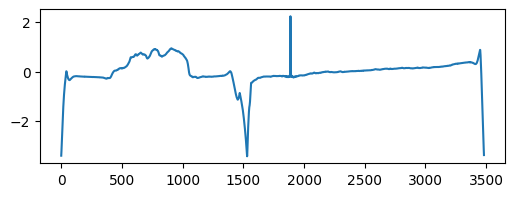

In [15]:
# plot imagelp and resulting_array one below the other
ax, fig = plt.subplots(figsize=(6, 2))
plt.plot(imagelp)




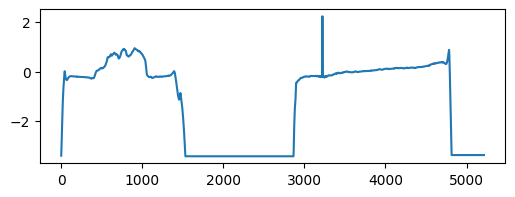

In [16]:
ax, fig = plt.subplots(figsize=(6, 2))
plt.plot(resulting_array)


In [17]:
X_data.shape

torch.Size([1, 1, 5216])

In [18]:
def label_to_class(label):
    # create a dictionary of labels to class
    label_to_class = {
        0: "FX00_Sporadic_line_artefacts",
        1: "FX02_Group_of_line_artefact",
        2: "FX03_partly_brighter",
        3: "FX04_group_of_defect_line",
        4: "FX05_Defect_line",
        5: "FX07_Stripes",
        6: "Good_image",
    }
    return label_to_class[label]

In [19]:
model_ft.eval()
with torch.no_grad():
    out = model_ft(X_data)
    #apply softmax
    out = nn.functional.softmax(out, dim=1)
    # get conf and label
    
    conf, label = torch.max(out, dim=1)
    print(out)
    print(torch.argmax(out))
    print(torch.argmax(out).item())
    print(label_to_class(torch.argmax(out).item()))
   

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[2.3714e-04, 7.8438e-05, 6.7517e-06, 1.1500e-04, 1.4944e-03, 9.7812e-01,
         1.9948e-02]])
tensor(5)
5
FX07_Stripes


In [20]:
probabilities = [round(v.item(),2) for v in (out[0])]
probabilities

[0.0, 0.0, 0.0, 0.0, 0.0, 0.98, 0.02]

Text(0.5, -0.37, 'Label: FX07_Stripes')

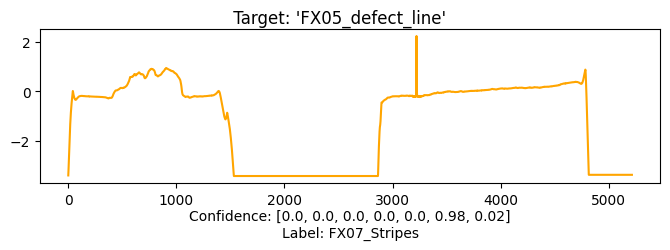

In [24]:
fig, ax = plt.subplots(figsize=(8,2),gridspec_kw={"top": 0.88})
# plt.imshow(image, cmap="gray")
# ax, fig = plt.subplots(figsize=(9, 2))
plt.plot(resulting_array, color="orange")
fig.suptitle(
    " Target: 'FX05_defect_line' "
)
ax.text(0.5, -0.26, f'Confidence: {probabilities}', ha='center',va='bottom', transform=ax.transAxes)
ax.text(0.5, -0.37, f'Label: {label_to_class(torch.argmax(out).item())}', ha='center',va='bottom', transform=ax.transAxes)


In [16]:
image= cv2.imread('/home/hpc/iwi5/iwi5095h/masterthesis/thesis/experiments/Line_profile/FX09_1_.tif', -1)
n = np.array(image)  
print(n.shape)
n_std=(n-n.mean())/n.std()
cols = n_std.mean(axis=0)
print(cols.shape)
rows = n_std.mean(axis=1)
print(rows.shape)
imagelp=np.concatenate((cols,rows),axis=0)

# 5216 

# repeat last value of imagelp array  of shape ( 5096,)to make it *(5216,)
repeat_count = 5216 - imagelp.shape[0]

# Get the last value of the original array
last_value = imagelp[-1]

# Create the repeated array
repeated_array = np.repeat(last_value, repeat_count)
resulting_array1 = np.concatenate((imagelp, repeated_array))

(2866, 2350)
(2350,)
(2866,)


In [22]:
image= cv2.imread('/home/hpc/iwi5/iwi5095h/masterthesis/thesis/experiments/Line_profile/FX09_3_.tif', -1)
n = np.array(image)  
print(n.shape)
n_std=(n-n.mean())/n.std()
cols = n_std.mean(axis=0)
print(cols.shape)
rows = n_std.mean(axis=1)
print(rows.shape)
imagelp=np.concatenate((cols,rows),axis=0)

# 5216 

# repeat last value of imagelp array  of shape ( 5096,)to make it *(5216,)
repeat_count = 5216 - imagelp.shape[0]

# Get the last value of the original array
last_value = imagelp[-1]

# Create the repeated array
repeated_array = np.repeat(last_value, repeat_count)
resulting_array2 = np.concatenate((imagelp, repeated_array))

(2866, 2350)
(2350,)
(2866,)


In [23]:
import cv2
import scipy.stats as stats

# Load and preprocess the images
image_postprocessed = cv2.imread('/home/hpc/iwi5/iwi5095h/masterthesis/thesis/experiments/Line_profile/FX09_3_.tif', -1)
image_raw=cv2.imread('/home/hpc/iwi5/iwi5095h/masterthesis/thesis/experiments/Line_profile/FX09_1_.tif', -1)
# Calculate histograms
hist_raw = cv2.calcHist([image_raw], [0], None, [256], [0, 256])
hist_postprocessed = cv2.calcHist([image_postprocessed], [0], None, [256], [0, 256])


In [88]:

# Perform the Kolmogorov-Smirnov test
_, p_value = stats.ks_2samp(resulting_array1, resulting_array2)

print(p_value)

if p_value < 0.05:
    print("Distributions are significantly different.")
else:
    print("Distributions are similar.")


8.673257136004402e-299
Distributions are significantly different.
